In [1]:
##Data Source:
#### http://ec.europa.eu/eurostat/data
#### http://ec.europa.eu/eurostat/web/products-datasets/-/ilc_di03

##Definition:
####http://measuring-progress.eu/median-equivalised-net-income

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')
sns.set()
%matplotlib inline

### Loading Data

In [3]:
## Load tab delimited "mean and median income by age and sex - EU-SILC survey (ilc_di03)" to pandas dataframe
file =pd.read_csv('./data/ilc_di03.tsv', sep='\t', header=0)

### Data preparation

In [4]:
#Split 'age,sex,indic_il,unit,geo\\time' to separate columns
file['Age'],file['Sex'],file['Indic_il'],file['Unit'],file['Country'] =file.loc[:,'age,sex,indic_il,unit,geo\\time'].str.split(',').str
file.drop('age,sex,indic_il,unit,geo\\time', axis =1, inplace=True)

#Replace ":" win NAN values
file.replace(': ', np.nan, inplace=True)

#Remove special characters
file.replace({' e': ''},regex=True, inplace=True)
file.replace({' b': ''},regex=True, inplace=True)
file.replace({' ': ''},regex=True, inplace=True)

In [5]:
#Dictionary mapping coutry code to country name
coutry_codes={'AT':'Austria', 'BE':'Belgium', 'BG':'Bulgaria', 'CH':'Switzerland', 'CY':'Cyprus', 'CZ':'Czech Republic', 'DE':'Germany', 'DK':'Denmark',
       'EE':'Estonia', 'EL':'Greece', 'ES':'Spain', 'FI':'Finland', 'FR':'France',
       'HR':'Croatia', 'HU':'Hungary', 'IE':'Ireland', 'IS':'Icland', 'IT':'Italy', 'LT':'Lithuania', 'LU':'Luxembourg', 'LV':'Latvia', 'MK':'Former Yugoslav Republic of Macedonia', 'MT':'Malta', 'NL':'Netherlands',
       'NO':'Norway', 'PL':'Poland', 'PT':'Portugal', 'RO':'Romania', 'RS':'Serbia', 'SE':'Sweden', 'SI':'Slovenia', 'SK':'Slovakia', 'TR':'Turkey', 'UK':'United Kingdom'}

In [6]:
#Replacing Country codes with country names
file.replace({'Country': coutry_codes}, inplace =True)

In [7]:
# Data structure change

cols = list(file.columns.values)        #Make a list of all of the columns in the file df
cols.pop(cols.index('Age'))             #Remove 'Age' from list
cols.pop(cols.index('Country'))         #Remove 'Country_Code' from list
cols.pop(cols.index('Indic_il'))        #Remove 'Indic_il' from list
cols.pop(cols.index('Sex'))             #Remove 'Sex' from list
cols.pop(cols.index('Unit'))            #Remove 'Unit' from list

#Create new dataframe with columns in the order I want
file = file[['Age','Indic_il','Sex','Unit','Country']+sorted(cols)]

file.head()

,Age,Indic_il,Sex,Unit,Country,1995,1996,1997,1998,1999,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
0,TOTAL,MED_E,F,EUR,Austria,13394,14277,13841,13677,13888,...,18838,20030,20566,20949,21183,21629,22712,22741,23202,NaN
1,TOTAL,MED_E,F,EUR,Belgium,13085,13735,13707,13669,13885,...,17592,18851,18963,19380,19688,20878,21189,21012,21526,NaN
2,TOTAL,MED_E,F,EUR,Bulgaria,NaN,NaN,NaN,NaN,NaN,...,2131,2762,2925,2814,2776,2860,3260,3236,3043,NaN
3,TOTAL,MED_E,F,EUR,Switzerland,NaN,NaN,NaN,NaN,NaN,...,26114,28003,29780,32911,38156,39783,37278,38361,43091,NaN
4,TOTAL,MED_E,F,EUR,Cyprus,NaN,NaN,NaN,NaN,NaN,...,15677,16005,15839,16580,16502,15437,14186,13618,13854,NaN


# Visualization

### Visualization of "Median equivalised net income grow in Poland"

In [8]:
# Data set used for plot
fplot=file.iloc[:,4:][(file.Country=="Poland") & (file.Age =='TOTAL') & (file.Indic_il=='MED_E') &
               (file.Sex =='T') & (file.Unit=='NAC')].set_index('Country')
fplot

,1995,1996,1997,1998,1999,2000,2001,2003,2004,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country,,,,,,,,,,,,,,,,,,,,,
Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11467,...,15720,17903,19065,20075,20849,21610,22399,23247,24618,NaN


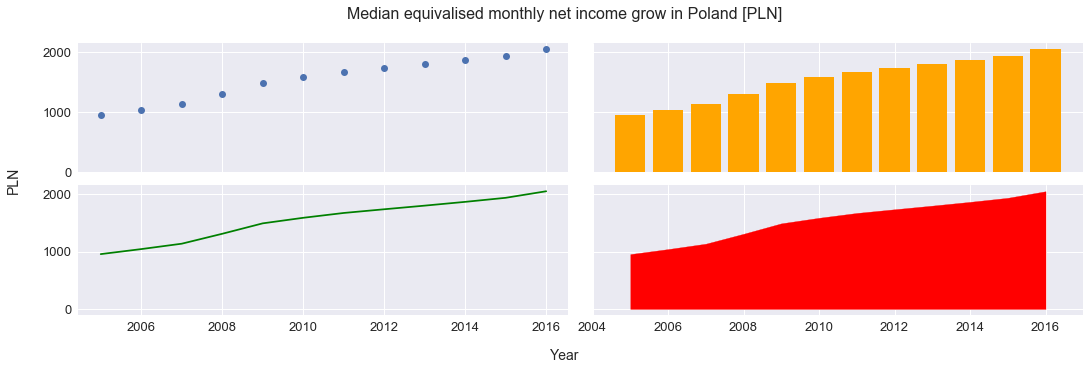

In [9]:
x = fplot.dropna(axis=1).columns.astype(int).tolist()         #explicity storing x dataset (although it is not required)
y = (fplot.dropna(axis=1).values[0].astype(int)/12).tolist()  #explicity storing y dataset (although it is not required)

fig, ax =plt.subplots(2, 2, figsize=(18,5), sharex='col', sharey='row')     #define sublopts grid and figure size
fig.subplots_adjust(hspace=0.1, wspace=0.05)                                #set up space between sublots 

plt.suptitle('Median equivalised monthly net income grow in Poland [PLN]', fontsize=16)
fig.text(0.5, 0.0, 'Year', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'PLN', va='center', rotation='vertical', fontsize=14)

for i in range(2):                                                          #define ticks size for all axis
    for j in range(2):
        ax[i,j].tick_params(axis='both',which ='both', labelsize=13)

ax[0,0].plot(x,y,'o')                                                       #scatter plot
ax[1,0].plot(x,y,'-', color='green')                                        #line plot
ax[0,1].bar(x,y, color ='orange');                                          #bar plot
ax[1,1].stackplot(x,y, color ='red');                                       #stackplot

### Visualization of "Median equivalised monthly net income prediction with using linear regression"

In 2020, median equivalised monthly net income in Poland will grow to  2495.6 zlotych per year
Coefficient of dermination [R2] is:  0.97


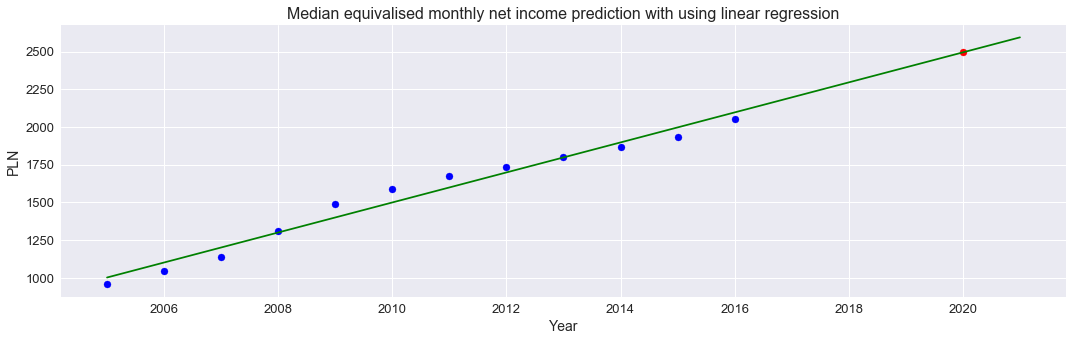

In [10]:
#Fitting line into points
fit = np.polyfit(x, y, deg=1)
x_n=x + [2020,2021]
y_n =[i*fit[0] +fit[1] for i in x_n]

plt.figure(figsize=(18,5))
print('In 2020, median equivalised monthly net income in Poland will grow to ', str(round(y_n[-2],1)), 'zlotych per year')

plt.title('Median equivalised monthly net income prediction with using linear regression', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.xticks(fontsize=13)
plt.ylabel("PLN", fontsize=14)
plt.yticks(fontsize=13)

plt.scatter(x,y, color = 'blue')
plt.scatter(x_n[-2],y_n[-2], color='red')
plt.plot(x_n,y_n, color='green');

coefficient_of_dermination = r2_score(y, y_n[:-2])

print('Coefficient of dermination [R2] is: ',round(coefficient_of_dermination,2))

### Visualization of "EU median equivalised monthly net income comparison"

In [11]:
# Data set used for plot
fplot=file[(file.Age =='TOTAL')           
           & (file.Indic_il=='MED_E')
           & (file.Sex =='T')
           & (file.Unit=='EUR')
           & (file.Country.isin(coutry_codes.values()))]\
    .drop(['Age', 'Sex','Indic_il','Unit'], axis=1).set_index('Country')[['2016 ']]\
    .dropna().astype('int64').sort_values(by='2016 ', ascending=False).reset_index()

fplot.head(7)

,Country,2016
0,Switzerland,44253
1,Norway,39573
2,Luxembourg,33818
3,Denmark,28665
4,Sweden,25164
5,Austria,23694
6,Finland,23650


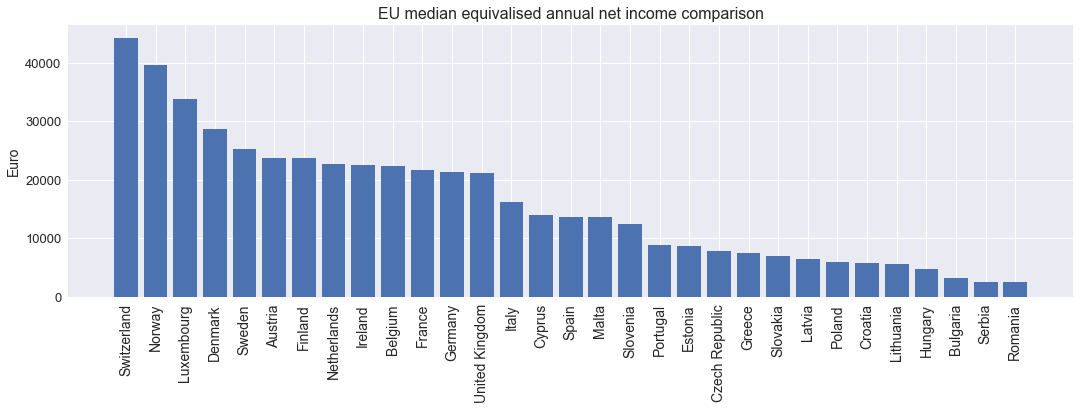

In [12]:
plt.figure(figsize=(18,5))  
x = fplot.index.values.tolist()
y = fplot['2016 '].values.tolist()

plt.title('EU median equivalised annual net income comparison', fontsize=16)
plt.bar(x,y)
plt.xticks(x, fplot['Country'].values.tolist(), rotation='vertical', fontsize=14)
plt.ylabel('Euro',fontsize=14)
plt.yticks (fontsize=13);

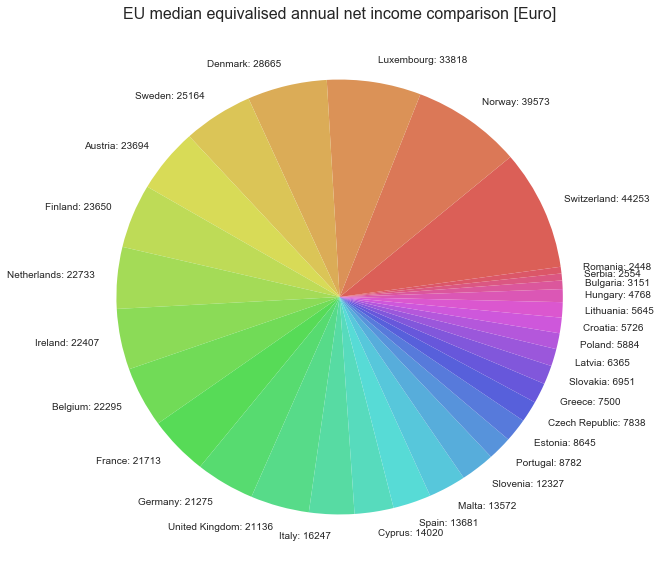

In [13]:
plt.figure(figsize=(10,10))
# Create a palette with unique colors
colors=sns.set_palette(sns.color_palette("hls", len(fplot.index)))  

labels =[str(i) + ": "+str(j) for i, j in zip(fplot['Country'].values.tolist(),y)] 
plt.title('EU median equivalised annual net income comparison [Euro]', fontsize=16)
plt.pie(y, labels=labels,colors=colors, startangle=8);


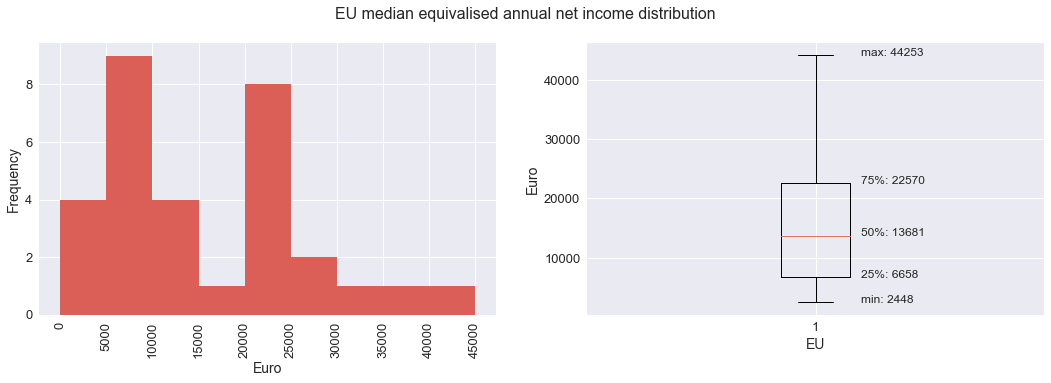

In [14]:

fig, ax =plt.subplots(1, 2, figsize=(18,5))                               #define sublopts grid and figure size
fig.subplots_adjust(wspace=0.2)                                           #set up space between sublots

plt.suptitle('EU median equivalised annual net income distribution', fontsize=16)

ax[0].hist(y, bins=(np.arange(0,50000, 5000)))                            #customize lebels and ticks
ax[0].set_xlabel('Euro', fontsize=14)
ax[0].set_ylabel('Frequency', fontsize=14)
ax[0].tick_params(axis='both',which ='both', labelsize=13)
ax[0].set_xticks(np.arange(0,50000, 5000))
plt.setp( ax[0].xaxis.get_majorticklabels(), rotation=90)

ax[1].boxplot(y)
ax[1].set_xlabel('EU', fontsize=14)
ax[1].set_ylabel('Euro', fontsize=14)
ax[1].tick_params(axis='both',which ='both', labelsize=13);

for index, values in fplot[['2016 ']].describe()[3:].iterrows():          #display text with stats  
    ax[1].text(1.1,values, index +': '+ str(int(values[0])), fontsize=12)

In [15]:
# Data set used for plot
fplot=file[(file.Age =='TOTAL')
           & (file.Country.isin(['Poland','Belgium', 'Spain', 'Slovakia', 'France', 'Greece','Romania','United Kingdom']))
           & (file.Indic_il=='MED_E')
           & (file.Sex =='T')
           & (file.Unit=='EUR')].drop(['Age', 'Sex','Indic_il','Unit'], axis=1).set_index('Country')
fplot

,1995,1996,1997,1998,1999,2000,2001,2003,2004,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Country,,,,,,,,,,,,,,,,,,,,,
Belgium,13405,14111,14089,14027,14200,14778,15492,15522,15674,16581,...,17985,19313,19464,20008,20280,21483,21705,21654,22295,NaN
Greece,5208,5467,5891,6413,6350,6924,7119,8206,8844,9417,...,10800,11496,11963,10985,9513,8371,7680,7520,7500,NaN
Spain,6173,6247,6619,6796,7485,8236,9034,NaN,10327,10453,...,13966,14795,14605,13929,13868,13524,13269,13352,13681,NaN
France,12653,13191,13353,13557,13814,14104,14889,NaN,15242,15946,...,18899,19644,19960,19995,20603,20924,21199,21415,21713,NaN
Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2533,...,4155,5097,4405,5025,5060,5164,5336,5556,5884,NaN
Romania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1952,2172,2036,2091,2049,2016,2155,2315,2448,NaN
Slovakia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2830,...,4792,5671,6117,6306,6927,6737,6809,6930,6951,NaN
United Kingdom,10429,10188,10962,13606,13814,15444,17724,NaN,NaN,18540,...,18923,16262,17106,17136,19166,18694,20528,21028,21136,NaN


### Visualization of "Median equivalised net income grow comparison"

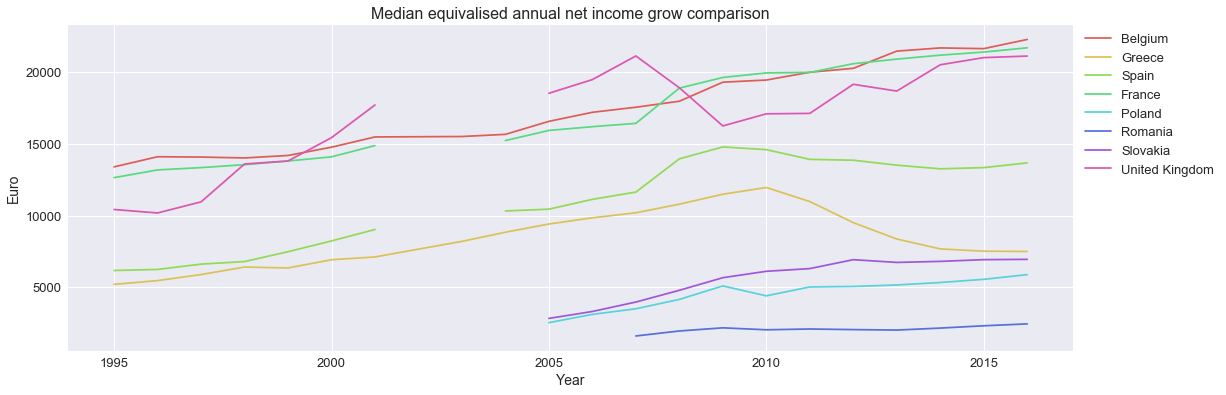

In [16]:
plt.figure(figsize=(18,6))                                                          # Setting up plot size
sns.set_palette(sns.color_palette("hls", len(fplot.index)))                         # Create a palette with unique colors
for index, row in fplot.iterrows():                                                 # Iterate through dataframe content 
    plt.plot(row, label =index)                                                     # and plot data for each country
    
plt.title('Median equivalised annual net income grow comparison', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Euro', fontsize=14)
plt.tick_params(axis='both',which ='both', labelsize=13)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5), ncol=1, prop={'size': 13});   # Plot Legeng and set up it's position

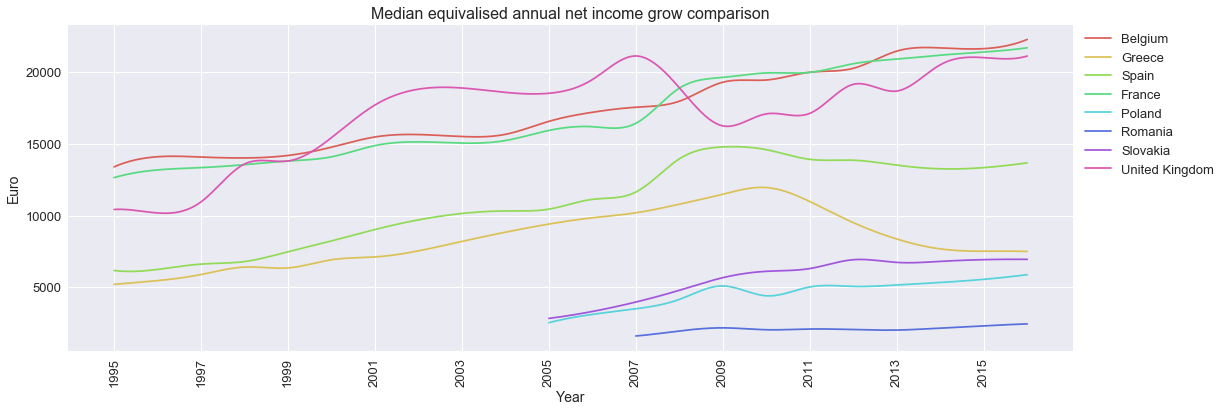

In [17]:
plt.figure(figsize=(18,6))                                                         # Setting up plot size

for index, row in fplot.iterrows():                                                # Interpolatinh NAN values
    y=row.interpolate(method='linear').dropna().values
    x=row.interpolate(method='linear').dropna().index.values.astype(float)
    
    x_s = np.linspace(x.min(),x.max(),500)                                         # Smoothing lines with Spline
    s = UnivariateSpline(x,y, k=3)
    y_s = s(x_s)
   
    plt.plot(x_s, y_s, label =index)

plt.title('Median equivalised annual net income grow comparison',{'size':'16'})
plt.xticks(np.arange(x.min(), x.max()+1, 2.0), rotation='vertical')                # Xticks roattion and distribution change 
plt.xlabel('Year', fontsize=14)
plt.ylabel('Euro', fontsize=14)
plt.tick_params(axis='both',which ='both', labelsize=13)
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5), ncol=1, prop={'size': 13});  # Plot Legend and set up it's position
